# Cardiomyocite

## Example ECG data
taken from https://www.physionet.org/content/autonomic-aging-cardiovascular/1.0.0/


In [2]:
using Pkg
Pkg.activate("../")
using CairoMakie
using Random
using Distributions
using StatsBase
using LinearAlgebra
using DSP
using JSON

# load path_figures from config_user.json if it exists
path_config = "../config_user.json"
if isfile(path_config)
    config = JSON.parsefile(path_config)
    path_figures = config["path_figures"]
else
    config = JSON.parsefile("../config_default.json")
    path_figures = config["path_figures"]
end
print(path_figures)

  Activating project at `~/git/projects/perspective_heart_and_brain`


"/Users/johannes/research/figures_perspective_heart_brain/subfigures/"

In [3]:
using DelimitedFiles
# wfdb format consists of a header file (hea) and a data file (dat)
base="../data/Schuhmann_Baer_PhysioNet_2021/0001"
# read header file line by line
hea = readlines(base * ".hea")
println(hea[1])
record = Dict()
# first line is general information, split the string
elements = split(hea[1])
record["name"] = elements[1]
record["n_sig"] = parse(Int, elements[2])
record["fs"]  = parse(Int, elements[3])
record["sig_len"] = parse(Int, elements[4])
# remaining rows describe signals
record["sig_name"] = Vector{String}(undef, record["n_sig"])
record["filename"] = Vector{String}(undef, record["n_sig"])
record["init_value"] = Vector{Int}(undef, record["n_sig"])
record["baseline"] = Vector{Float64}(undef, record["n_sig"])
record["adc_gain"] = Vector{Float64}(undef, record["n_sig"])
for i in 2:length(hea)
    elements = split(hea[i])
    record["filename"][i-1] = elements[1]
    dac = elements[3]
    baseline, _dac = split(dac, "(")
    record["adc_gain"][i-1] = parse(Float64, baseline)
    gain, _ = split(_dac, ")")
    record["baseline"][i-1] = parse(Float64, gain)
    record["init_value"][i-1] = parse(Int, elements[6])
    record["sig_name"][i-1] = elements[8]
end
# extract information from header file
println(record["filename"])
println(record["init_value"])
println(record["sig_name"])

# based on header read in the data file
samples = zeros(UInt16, record["n_sig"], record["sig_len"])
println(size(samples))
ne = 0;
open(base * ".dat", "r") do io
    for j in 1:record["sig_len"]
        for i in 1:record["n_sig"]
            samples[i,j] = read(io, UInt16)
        end
    end
end
time = 0:1/record["fs"]:(record["sig_len"]-1)/record["fs"]

0001 3 1000 900401
["0001.dat", "0001.dat", "0001.dat"]
[5833, -15951, -20028]
["0", "0", "0"]
(3, 900401)


0.0:0.001:900.4

In [4]:
# DAC (digital to analog conversion) to obtain the "p_signal" (c.f. https://github.com/MIT-LCP/wfdb-python/blob/main/wfdb/io/_signal.py#L590)
# `digital - baseline / adc_gain = physical`
d_signal = (Float64.(samples) .- record["baseline"]) ./ record["adc_gain"]
samples = d_signal

3×900401 Matrix{Float64}:
   0.186327    0.189795    0.198486    0.203709  …   -0.0207648   -0.046282
   1.2412      1.22788     1.21978     1.22152        1.3952       1.24177
 183.269     183.252     183.235     183.219        153.163      152.647

In [5]:
mask = 0.3 .< time .< 2.3;
mtime = time[mask]
msamples = samples[:, mask]

3×1999 Matrix{Float64}:
   0.207177    0.211245    0.218223  …    0.253588    0.255343    0.251875
   1.20529     1.20124     1.21282        1.25336     1.25045     1.23946
 192.681     192.725     192.769        187.885     187.914     187.942

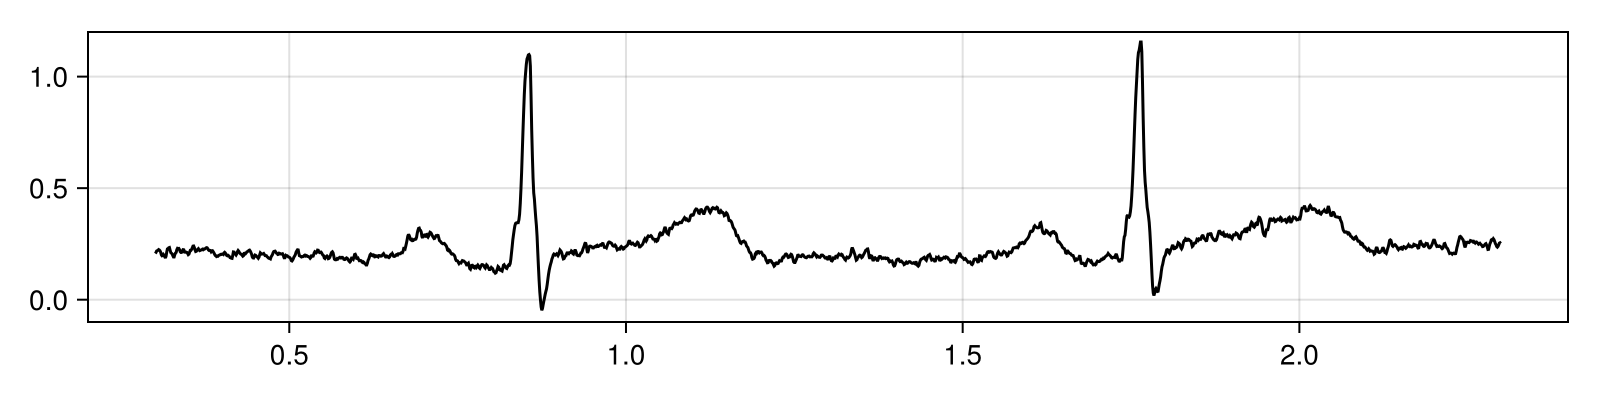

In [14]:
fig = Figure(size = (800, 200))
ax = Axis(fig[1, 1])
lines = lines!(ax, mtime, msamples[1, :], color = :black)
ymin=-0.1
ymax=1.2
dy=(ymax-ymin)/15
ylims!(ax, (ymin,ymax)) # 1.5mV
fig

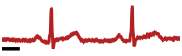

In [ ]:
# plot the data (consistent with ecg_data from wfdb packages in python)
mm = 2.83465 # pt
fig = Figure(size = (32*mm, 10*mm), fontsize=10, figure_padding = 1, backgroundcolor = :transparent)
ax = Axis(fig[1,1]; xgridvisible = false, ygridvisible = false, backgroundcolor = :transparent)
hidedecorations!(ax)
hidespines!(ax)
lines!(ax, mtime.-0.3, msamples[1,:], color = colorant"firebrick")
xlims!(ax, (0, 2.0))
ymin=-0.1
ymax=1.2
dy=(ymax-ymin)/13
ylims!(ax, (ymin,ymax)) # 1.3mV
# include a scale for the time
dt = 0.2
ts = 0.0 .+ [0,dt]
band!(ts, ones(length(ts)) * (ymin + dy), ones(length(ts)) * (ymin + 2 * dy), color=colorant"black")
# save as pdf with transparent background
save(path_figures*"ecg_example.pdf", fig, pt_per_unit = 1)
fig